# Author's Notes

May 2021 Update: We now generate tab-delimited files (TSVs) for each clustering algo. You can load the first three dimensions along with the labels in [Tensorboard Projector](https://projector.tensorflow.org) to visualize  clustering in 3-D space.

From [Hands-on Unsupervised Learning using Python](https://amzn.to/2tVABNx) - Chapter 5 - Clustering

# Google Colab Setup
**Only for users on Google Colab**

In [46]:
"""
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
connectDrive()

# Change path
changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")
"""

'\n# Define functions to connect to Google and change directories\ndef connectDrive():\n    from google.colab import drive\n    drive.mount(\'/content/drive\', force_remount=True)\n\ndef changeDirectory(path):\n    import os\n    original_path = os.getcwd()\n    os.chdir(path)\n    new_path = os.getcwd()\n    print("Original path: ",original_path)\n    print("New path: ",new_path)\n\n# Connect to Google Drive\nconnectDrive()\n\n# Change path\nchangeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")\n'

In [47]:
!pip install --upgrade pip setuptools


In [48]:
# !pip install fastcluster==1.1.26
!pip install fastcluster==1.2.6

In [49]:
# Install additional libraries
# ogcode Lib version but get error so  upgrade 1.2.6
# !pip install fastcluster==1.1.26

!pip install hdbscan==0.8.27

# Import Libraries

In [50]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

# Load Data

In [51]:
# Load the datasets
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'mnist_data', 'mnist.pkl.gz'])

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [52]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train), \
                         len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

# Dimensionality Reduction

In [53]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [54]:
 # Log data
cwd = os.getcwd()
log_dir = cwd+"/logs/05_clustering/"
y_train[0:2000].to_csv(log_dir+'labels.tsv', sep = '\t', index=False, header=False)

In [55]:
# Write dimensions to CSV
X_train_PCA.iloc[0:2000,0:3].to_csv(log_dir+'pca_data.tsv', sep = '\t', index=False, header=False)

# K-means
- 클러스터링의 목적은 그룹 내 관측치는 서로 유사하지만 다른 그룹의 관측치와는     
  다르게 구별되는 그룹의 데이터셋을 식별하는 것    

- 알고리즘은 군집 내 분산(within-cluster variation)(a.k.a 관성)     
  최소화해 그룹을 최적화 즉 모든 k개 군집별 군진 내 분산의 합이 가능한 한 작아지도록 함    
  

## Inertia   

In [56]:
# K-means - Inertia as the number of clusters varies
from sklearn.cluster import KMeans

n_clusters = 10                 #군집의 수
n_init = 10                     #최기화 횟수
max_iter = 300                  #최대 반복 횟수
tol = 0.0001                    #수렴 허용 오차
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=range(2,21), \
                              columns=['inertia'])
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

<AxesSubplot:>

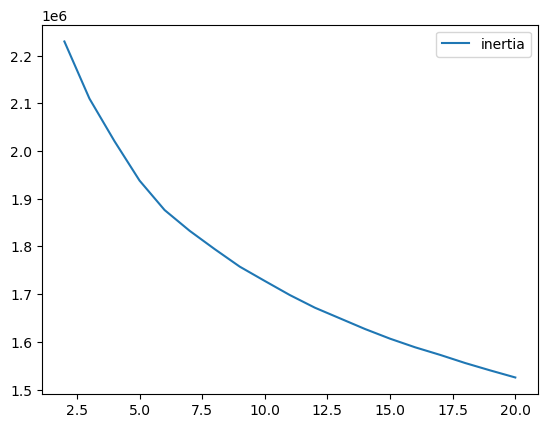

In [57]:
# Plot inertia relative to k # of clusters
kMeans_inertia.plot()

## Accuracy    

In [58]:
# Define analyze cluster function
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = \
        pd.DataFrame(data=preds.groupby('cluster').agg( \
                        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
                        left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
                        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
                        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
            accuracyDF, overallAccuracy, accuracyByLabel

In [59]:
# K-means - Accuracy as the number of clusters varies

n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = \
    pd.DataFrame(data=[],index=range(2,21),columns=['inertia'])
overallAccuracy_kMeansDF = \
    pd.DataFrame(data=[],index=range(2,21),columns=['overallAccuracy'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = \
        pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, \
                     columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

<AxesSubplot:>

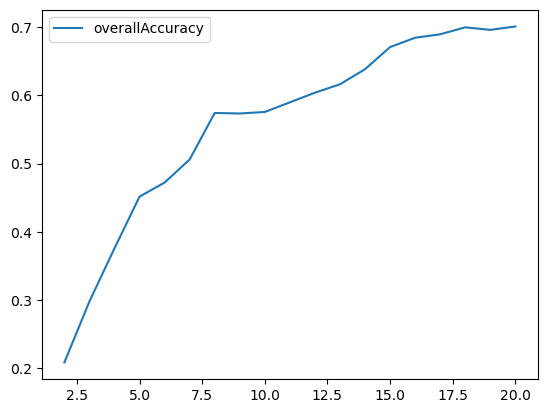

In [60]:
# Plot accuracy
overallAccuracy_kMeansDF.plot()

In [61]:
# Accuracy by cluster
accuracyByLabel_kMeans

0     0.928172
1     0.849176
2     0.874955
3     0.455545
4     0.592881
5     0.385702
6     0.932873
7     0.721638
8     0.495248
9     0.847841
10    0.891425
11    0.636328
12    0.916874
13    0.956971
14    0.942112
15    0.379933
16    0.464061
17    0.793194
18    0.528749
19    0.949918
dtype: float64

In [62]:
# View cluster labels
X_train_kmeansClustered

,cluster
0,7
1,6
2,3
3,9
4,15
...,...
49995,8
49996,13
49997,5
49998,16


In [63]:
# Save cluster labels
X_train_kmeansClustered[0:2000].to_csv(log_dir+'kmeans_cluster_labels.tsv', sep = '\t', index=False, header=False)

## Accuracy as the number of principal components varies

In [64]:
# K-means - Accuracy as the number of components varies

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

<AxesSubplot:>

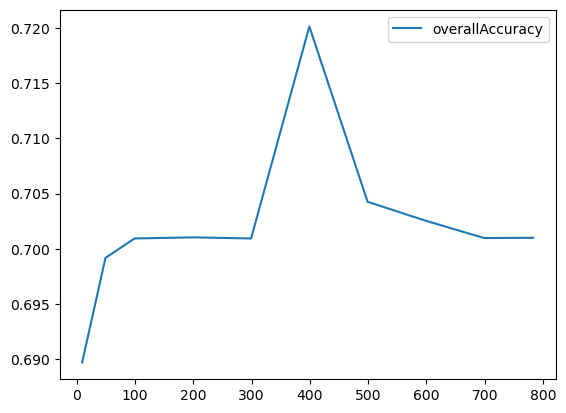

In [65]:
# Accuracy relative to number of principal components
overallAccuracy_kMeansDF.plot()

## Accuracy as the number of original dimensions varies

In [66]:
# K-means - Accuracy as the number of components varies
# On the original MNIST data (not PCA-reduced)

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state)

    cutoff = cutoffNumber
    kmeans.fit(X_train.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

/var/folders/kv/vn32wd3d3h31mygq2s73s8w80000gn/T/ipykernel_53150/2405941189.py:22: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  kmeans.fit(X_train.loc[:,0:cutoff])


<AxesSubplot:>

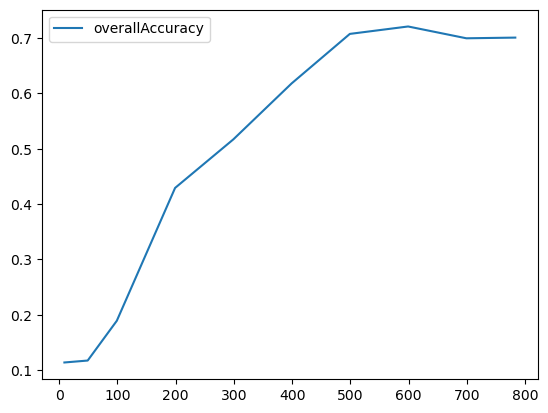

In [67]:
# Accuracy relative to number of original dimensions
overallAccuracy_kMeansDF.plot()

# Hierarchical clustering    
- 특정한 군집의 개수를 사전에 설정 x.   
  대신 계층적 클러스터링 실행이 종료되면 우리가 원하는 군집의 개수를 선택가능    

- Hierarchical clustering 알고리즘은 데이터셋의 관측치를 사용해 ***덴드로그램***을 만듬    
  댄드로 그램은 트리 잎이 아래쪽에 있고 나무 줄기가 맨위에 있는 뒤집힌 트리로 나타낼 수 있음     

- 맨 아래 잎은 데이터셋의 개별 인스턴스. 계층적 클러스터링은 서로 얼마나 유사한지에 따라    
  뒤집힌 트리를 수직 위로 이동하면서 잎을 결합    

- 서로 가장 유사한 인스턴스(또는 인스턴스 그룹)는 더욱 빨리 결합하고 유사하지 않은 인스턴스는 나중에 결합   

   
#### 병합 계층적 클러스터링   
- fastcluster라는 라이브러리 사용(Python/Scipy 인터페이스를 제공하는 C++ 라이브러리)     
- ward는 와드의 최소 분산 방법
  - https://en.wikipedia.org/wiki/Ward's_method

- 척도는 대부분 euclidean으로 설정(centroid, median, ward must euclidean)

In [68]:
# Perform hierarchical clustering
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

cutoff = 99
Z = fastcluster.linkage_vector(X_train_PCA.loc[:,0:cutoff], \
                               method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, \
    columns=['clusterOne','clusterTwo','distance','newClusterSize'])

In [69]:
# Show leaves
Z_dataFrame.iloc[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,42194.0,43025.0,0.562681,2.0
1,28350.0,37674.0,0.590865,2.0
2,26696.0,44705.0,0.621506,2.0
3,12634.0,32823.0,0.627761,2.0
4,24707.0,43151.0,0.637666,2.0
5,20465.0,24483.0,0.662557,2.0
6,466.0,42098.0,0.664189,2.0
7,46542.0,49961.0,0.665519,2.0
8,2301.0,5732.0,0.671216,2.0
9,37564.0,47668.0,0.675120,2.0


In [70]:
# Show leaves higher on the tree
Z_dataFrame.iloc[49980:]

,clusterOne,clusterTwo,distance,newClusterSize
49980,99965.0,99972.0,161.107008,5197.0
49981,99932.0,99980.0,172.070013,6505.0
49982,99945.0,99960.0,182.840885,3245.0
49983,99964.0,99976.0,184.475807,3683.0
49984,99974.0,99979.0,185.027832,7744.0
49985,99940.0,99975.0,185.345183,5596.0
49986,99957.0,99967.0,211.854777,5957.0
49987,99938.0,99983.0,215.494914,4846.0
49988,99978.0,99984.0,216.760433,11072.0
49989,99970.0,99973.0,217.355972,4899.0


In [71]:
# Create clusters
from scipy.cluster.hierarchy import fcluster

distance_threshold = 160
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = \
    pd.DataFrame(data=clusters,index=X_train_PCA.index,columns=['cluster'])

In [72]:
# Print number of clusters
print("Number of distinct clusters: ", \
      len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  20


In [73]:
# Show overall accuracy
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust \
    = analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", \
      overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.76882


In [74]:
# Show accuracy by cluster
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.987962
1     0.983727
2     0.988998
3     0.597356
4     0.678642
5     0.442478
6     0.950033
7     0.829060
8     0.976062
9     0.986141
10    0.990183
11    0.992183
12    0.971033
13    0.554273
14    0.553617
15    0.720183
16    0.538891
17    0.484590
18    0.957732
19    0.977310
dtype: float64

In [75]:
# View cluster labels
X_train_hierClustered

,cluster
0,5
1,3
2,15
3,11
4,14
...,...
49995,4
49996,3
49997,6
49998,14


In [76]:
# Save cluster labels
X_train_hierClustered[0:2000].to_csv(log_dir+'hierarchical_cluster_labels.tsv', sep = '\t', index=False, header=False)

# DBSCAN    
(density-based spatial clustering of application with noise).   

- 두 데이터 포인트가 이웃이 되기 위한 조건인 두 포인트 사이의 최대 거리(maximum distance)(eps)       
  와 그룹을 군집이라 부르기 위한 최소 샘플(minimum smaples(min_samples)을 설정해야 함

In [77]:
# Perform DBSCAN
from sklearn.cluster import DBSCAN

eps = 3
min_samples = 5
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)

cutoff = 99
X_train_PCA_dbscanClustered = db.fit_predict(X_train_PCA.loc[:,0:cutoff])
X_train_PCA_dbscanClustered = \
    pd.DataFrame(data=X_train_PCA_dbscanClustered, index=X_train.index, \
                 columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, \
    accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan \
    = analyzeCluster(X_train_PCA_dbscanClustered, y_train)

overallAccuracy_dbscan

0.242

In [78]:
# Print overall accuracy
print("Overall accuracy from DBSCAN: ",overallAccuracy_dbscan)

Overall accuracy from DBSCAN:  0.242


In [79]:
# Show cluster results
print("Cluster results for DBSCAN")
countByCluster_dbscan

Cluster results for DBSCAN


,cluster,clusterCount
0,-1,39575
1,0,8885
2,8,720
3,5,92
4,18,51
...,...,...
95,57,4
96,43,4
97,89,4
98,54,3


In [80]:
# View cluster labels
X_train_PCA_dbscanClustered

,cluster
0,-1
1,-1
2,-1
3,0
4,-1
...,...
49995,-1
49996,-1
49997,-1
49998,-1


In [81]:
# Save cluster labels
X_train_PCA_dbscanClustered[0:2000].to_csv(log_dir+'dbscan_cluster_labels.tsv', sep = '\t', index=False, header=False)

# HDBSCAN
(hierarchical DBSCAN).  

In [82]:
# !pip install hdbscan

In [85]:
# Perform HDBSCAN
import hdbscan

min_cluster_size = 30
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
        min_samples=min_samples, alpha=alpha, \
        cluster_selection_method=cluster_selection_method)

cutoff = 10
X_train_PCA_hdbscanClustered = \
    hdb.fit_predict(X_train_PCA.loc[:,0:cutoff])

X_train_PCA_hdbscanClustered = \
    pd.DataFrame(data=X_train_PCA_hdbscanClustered, \
    index=X_train.index, columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan \
    = analyzeCluster(X_train_PCA_hdbscanClustered, y_train)

TypeError: get_clusters() takes at most 6 positional arguments (7 given)

In [ ]:
# Print overall accuracy
print("Overall accuracy from HDBSCAN: ",overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.24694


In [ ]:
# Show cluster size
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,42569
1,4,5140
2,6,943
3,0,605
4,7,294
5,3,252
6,1,119
7,5,45
8,2,33


In [ ]:
# View cluster labels
X_train_PCA_hdbscanClustered

,cluster
0,-1
1,0
2,-1
3,4
4,-1
...,...
49995,-1
49996,-1
49997,-1
49998,-1


In [ ]:
# Save cluster labels
X_train_PCA_hdbscanClustered[0:2000].to_csv(log_dir+'hdbscan_cluster_labels.tsv', sep = '\t', index=False, header=False)

# Conclusion

In [ ]:
import datetime as dt
print("Completed: ", dt.datetime.now())

Completed:  2021-05-05 20:11:58.402559
